# CLASS ACTIVATION MAP

In [1]:
ls ../../ 

advanced-tensorflow/    JSAnimation/
coco-caption/           MNIST_data/
datasets/               models/
DCGAN-tensorflow/       reinforcement-learning/
deep-learning-cpslab/   show-attend-and-tell-tensorflow/
DeepLearningZeroToAll/  srez/
Faster-RCNN_class/      Tensorflow-101/
img_dataset/            tf_seq2seq_wrapper/


In [2]:
import sys
sys.path.append("../../models/slim")

In [3]:
import urllib, os
import tarfile
import numpy as np
import scipy.misc
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
# from tensorflow.contrib.slim.nets import resnet_v1
from nets import resnet_v1
%matplotlib inline
print ("PACKAGES LOADED")

PACKAGES LOADED


## DOWNLOAD PRETRAINED NET

In [4]:
# MAKE PATH IF NECESSARY 
dirpath = "data/"
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
# DOWNLOAD 
urlpath = "http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz"
zname   = "data/resnet_v1_50_2016_08_28.tar.gz"
if not os.path.exists(zname):
    print ("DOWNLOADING %s..." % (zname))
    urllib.urlretrieve(urlpath, zname)
    print ("DONE")
else:
    print ("%s ALREADY EXISTS" % (zname))

data/resnet_v1_50_2016_08_28.tar.gz ALREADY EXISTS


## UNZIP CKPT

In [5]:
fname = "data/resnet_v1_50_2016_08_28"
if not os.path.exists(fname):
    print ("EXTRACTING %s..." % (fname))
    tar = tarfile.open(zname, "r:gz")
    tar.extractall(path=fname)
    tar.close()
    print ("DONE.")
else:
    print ("%s ALREADY EXIST" % (fname))

data/resnet_v1_50_2016_08_28 ALREADY EXIST


## UTILITY FUNCTIONS

In [6]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))
print ("UTILITY FUNCTIONS")

UTILITY FUNCTIONS


## LOAD CALTECH 101

In [7]:
cwd = os.getcwd()
path = cwd + "/data/101_ObjectCategories"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
imgs = []
labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    if i == 0:
        continue
    for f in os.listdir(path + "/" + category):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_exts:
            continue
        fullpath = os.path.join(path + "/" + category, f)
        img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
        imgs.append(img) # NORMALIZE IMAGE 
        label_curr = np.zeros((ncategories))
        label_curr[i] = 1
        labels.append(label_curr)
print ("Num imgs: %d" % (len(imgs)))
print ("Num labels: %d" % (len(labels)) )

[102] CATEGORIES ARE IN 
 /home/sj/code/notebooks_docker/github/advanced-tensorflow/cam/data/101_ObjectCategories
Num imgs: 8677
Num labels: 8677


## DIVIDE THE DATASET INTO TWO

In [8]:
ndata = len(imgs)
ntrain = int(ndata*0.7) # WILL USE 70% FOR TRAINING
ntest = ndata-ntrain
randidx = np.random.permutation(ndata)
trainidx = randidx[:ntrain]
testidx = randidx[ntrain+1:]
train_imgs = [imgs[idx] for idx in trainidx]
train_labels = [labels[idx] for idx in trainidx]
test_imgs = [imgs[idx] for idx in testidx]
test_labels = [labels[idx] for idx in testidx]
# TENSORIZE DATA 
train_imgs_tensor = np.stack(train_imgs, axis=0)
train_labels_tensor = np.stack(train_labels, axis=0)
test_imgs_tensor = np.stack(test_imgs, axis=0)
test_labels_tensor = np.stack(test_labels, axis=0)
print "Num train_imgs: %d" % (len(train_imgs))
print "Num test_imgs: %d" % (len(test_imgs))
print_np(train_imgs_tensor, "train_imgs_tensor")
print_np(train_labels_tensor, "train_labels_tensor")
print_np(test_imgs_tensor, "test_imgs_tensor")
print_np(test_labels_tensor, "test_labels_tensor")
# REMOVE LISTS FROM MEMORY
del train_imgs, train_labels, test_imgs, test_labels

Num train_imgs: 6073
Num test_imgs: 2603
Type of 'train_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'train_imgs_tensor' is (6073, 224, 224, 3)
Type of 'train_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'train_labels_tensor' is (6073, 102)
Type of 'test_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'test_imgs_tensor' is (2603, 224, 224, 3)
Type of 'test_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'test_labels_tensor' is (2603, 102)


## PLOT DATASET

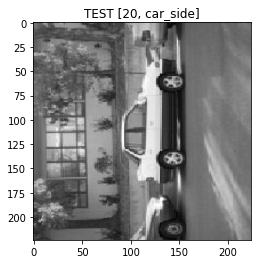

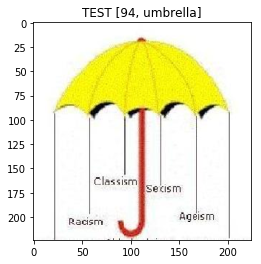

In [9]:
randidx = np.sort(np.random.randint(ntrain, size=2))
for i, j in enumerate(randidx):
    curr_img = train_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(train_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TRAIN [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()
randidx = np.sort(np.random.randint(ntest, size=2))
for i, j in enumerate(randidx):
    curr_img = test_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(test_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TEST [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()

## OPEN SESSION

In [10]:
sess = tf.Session()
print ("OPEN SESSION")

OPEN SESSION


## RESNET_V1_50 

In [11]:
x = tf.placeholder(shape=[None, 224, 224, 3], dtype=tf.float32)
with slim.arg_scope(resnet_v1.resnet_arg_scope()):
    mean = tf.constant([123.68, 116.779, 103.939],
        dtype=tf.float32, shape=[1, 1, 1, 3], name='img_mean')
    im_centered = x - mean
    net, end_points = resnet_v1.resnet_v1_50(inputs=im_centered
                    , num_classes=1000, is_training=False)
    b1 = end_points['resnet_v1_50/block1']

variables_to_restore = slim.get_variables_to_restore(include=["resnet_v1"])
restorer = tf.train.Saver(variables_to_restore)
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())
restorer.restore(sess, fname+"/resnet_v1_50.ckpt") 
print ("RESNET V1-50 RESTORED")

INFO:tensorflow:Restoring parameters from data/resnet_v1_50_2016_08_28/resnet_v1_50.ckpt
RESNET V1-50 RESTORED


In [21]:
b1

<tf.Tensor 'resnet_v1_50/block1/unit_3/bottleneck_v1/Relu:0' shape=(?, 28, 28, 256) dtype=float32>

In [12]:
?resnet_v1.resnet_v1_50

## DEFINE NETWORK

In [13]:
# PARAMETERS
n_output = ncategories
y = tf.placeholder('float', [None, n_output])
kr = tf.placeholder('float')
weights = {
    'out': tf.Variable(tf.random_normal([256, n_output], stddev=0.1))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output], stddev=0.1))
}
# NETWORK
def cam(_x, _W, _b, _kr):
    gap = tf.nn.avg_pool(_x, ksize=[1, 28, 28, 1], strides=[1, 28, 28, 1],
            padding='SAME')
    gap_dr = tf.nn.dropout(gap, _kr)
    gap_vec = tf.reshape(gap_dr, [-1, _W['out'].get_shape().as_list()[0]])
    out = tf.add(tf.matmul(gap_vec, _W['out']), _b['out'])
    ret = {'x': _x, 'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}
    return ret
print ("NETWORK READY")

NETWORK READY


## FUNCTIONS

In [14]:
gap  = cam(b1, weights, biases, kr)['x']
pred = cam(b1, weights, biases, kr)['out']
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y))
optm = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(cost)
corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accr = tf.reduce_mean(tf.cast(corr, 'float'))
init = tf.global_variables_initializer()
saver = tf.train.Saver(max_to_keep=3) 
print ("FUNCTIONS READY")

FUNCTIONS READY


## INIT

In [15]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)

## TRAIN THE NETWORK

[0/100] cost: 219.0304 train_acc: 0.133 test_acc: 0.133
PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 94  (umbrella)


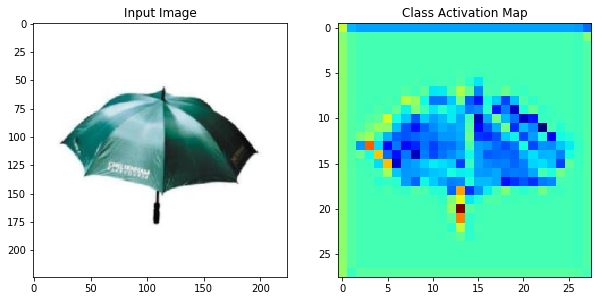

PREDICTED CLASS : 93  (trilobite)
     TRUE CLASS : 96  (water_lilly)


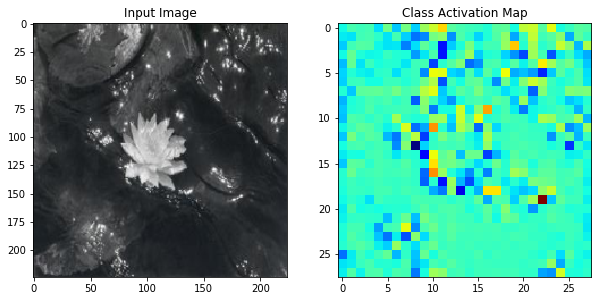

PREDICTED CLASS : 42  (flamingo)
     TRUE CLASS : 59  (llama)


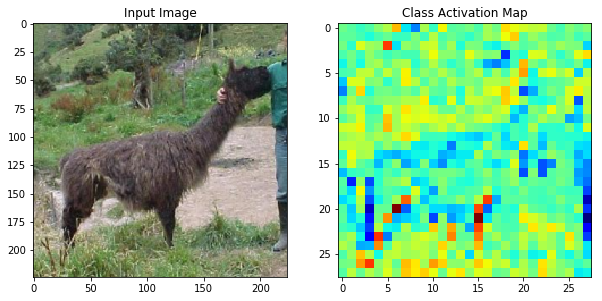

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 84  (snoopy)


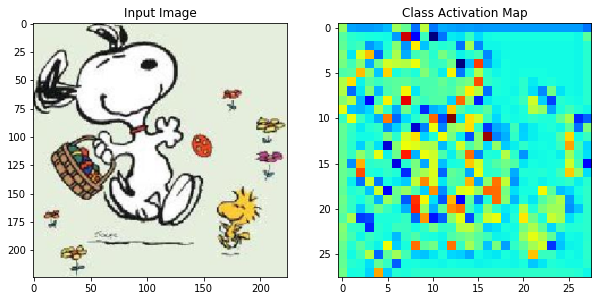

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 70  (pagoda)


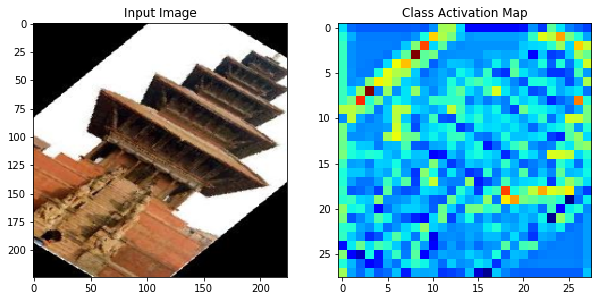

[5/100] cost: 3.9755 train_acc: 0.297 test_acc: 0.211
[10/100] cost: 3.6334 train_acc: 0.320 test_acc: 0.242
PREDICTED CLASS : 93  (trilobite)
     TRUE CLASS : 63  (mayfly)


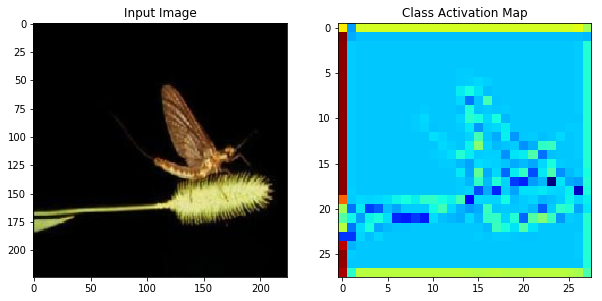

PREDICTED CLASS : 2  (Faces_easy)
     TRUE CLASS : 2  (Faces_easy)


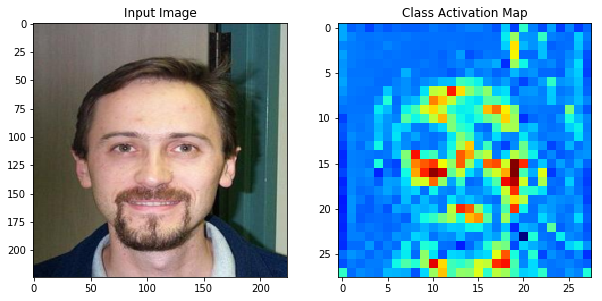

PREDICTED CLASS : 3  (Leopards)
     TRUE CLASS : 35  (dragonfly)


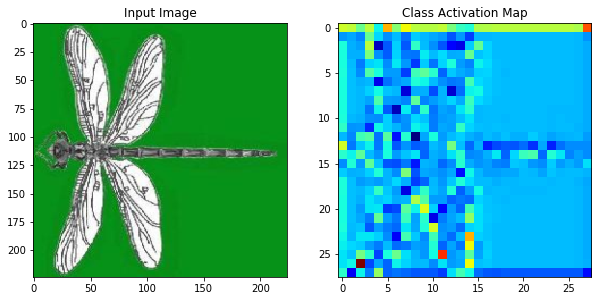

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 85  (soccer_ball)


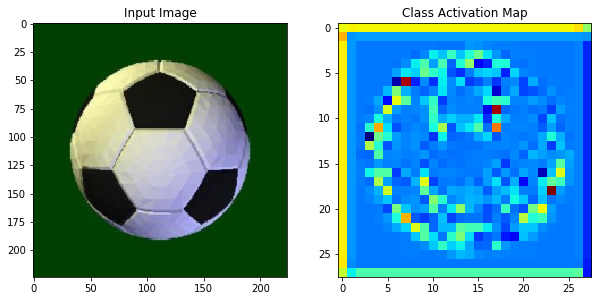

PREDICTED CLASS : 51  (helicopter)
     TRUE CLASS : 56  (ketch)


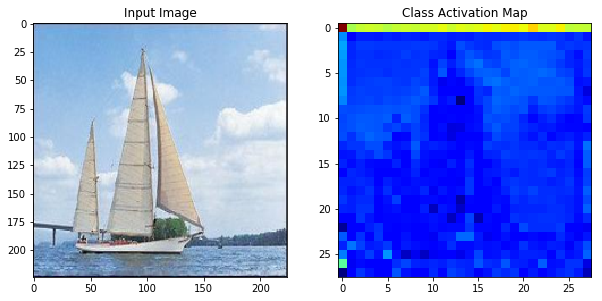

[15/100] cost: 3.4435 train_acc: 0.297 test_acc: 0.328
[20/100] cost: 3.2549 train_acc: 0.312 test_acc: 0.250
PREDICTED CLASS : 27  (crab)
     TRUE CLASS : 82  (scorpion)


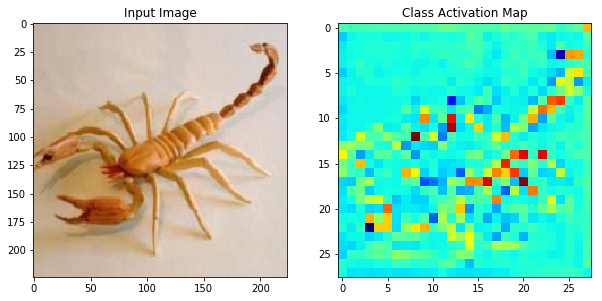

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 49  (headphone)


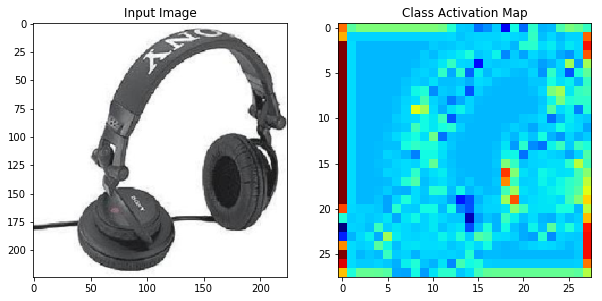

PREDICTED CLASS : 16  (buddha)
     TRUE CLASS : 26  (cougar_face)


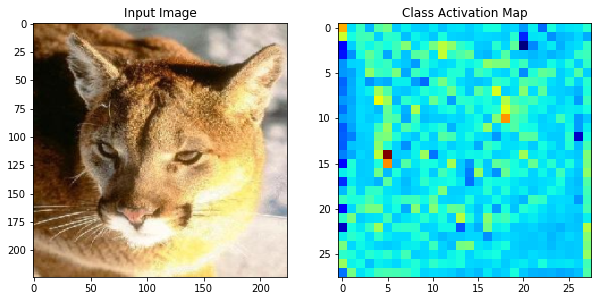

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 24  (chandelier)


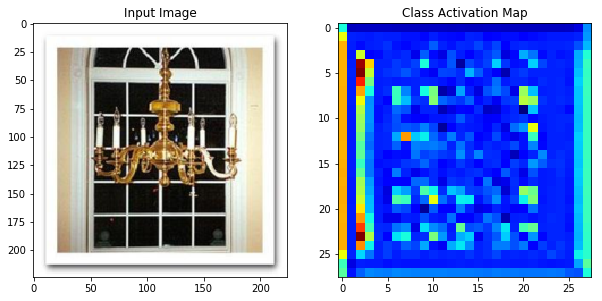

PREDICTED CLASS : 20  (car_side)
     TRUE CLASS : 20  (car_side)


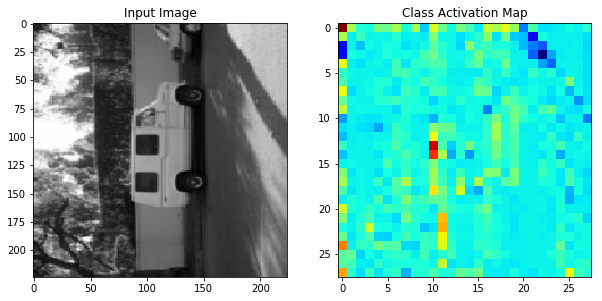

[25/100] cost: 3.1404 train_acc: 0.273 test_acc: 0.344
[30/100] cost: 3.0471 train_acc: 0.414 test_acc: 0.320
PREDICTED CLASS : 55  (kangaroo)
     TRUE CLASS : 59  (llama)


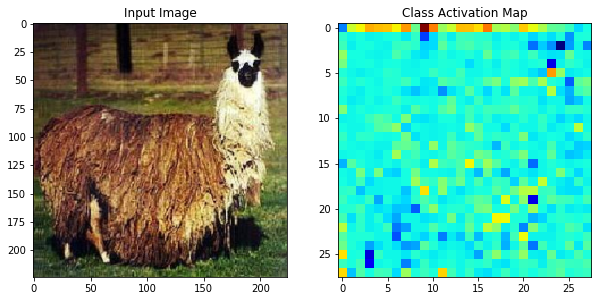

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 58  (laptop)


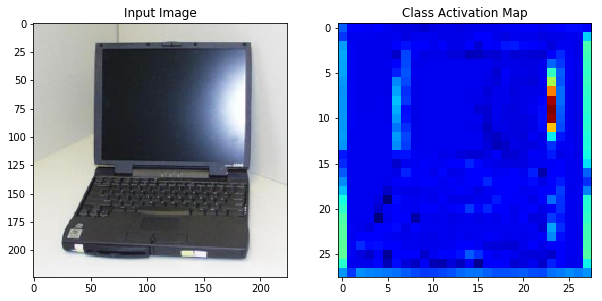

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 4  (Motorbikes)


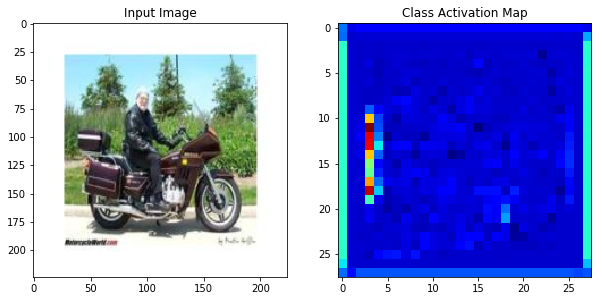

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 6  (airplanes)


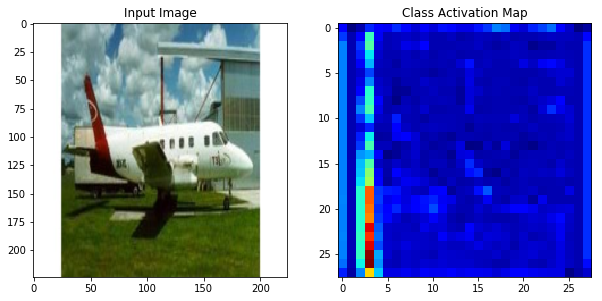

PREDICTED CLASS : 95  (watch)
     TRUE CLASS : 42  (flamingo)


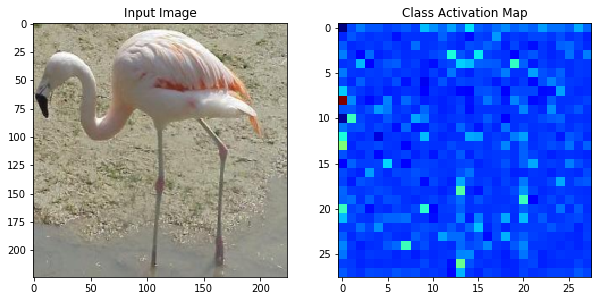

[35/100] cost: 2.9359 train_acc: 0.461 test_acc: 0.367
[40/100] cost: 2.8708 train_acc: 0.391 test_acc: 0.312
PREDICTED CLASS : 5  (accordion)
     TRUE CLASS : 93  (trilobite)


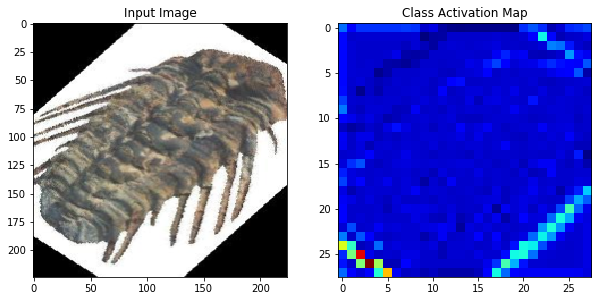

PREDICTED CLASS : 9  (barrel)
     TRUE CLASS : 76  (revolver)


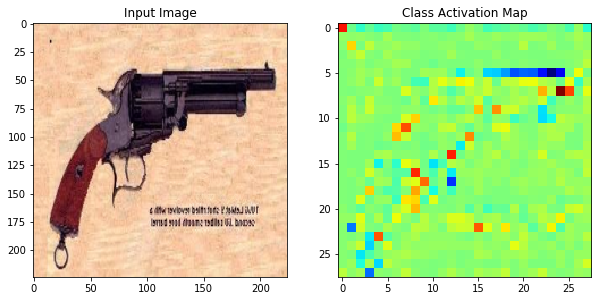

PREDICTED CLASS : 9  (barrel)
     TRUE CLASS : 72  (pigeon)


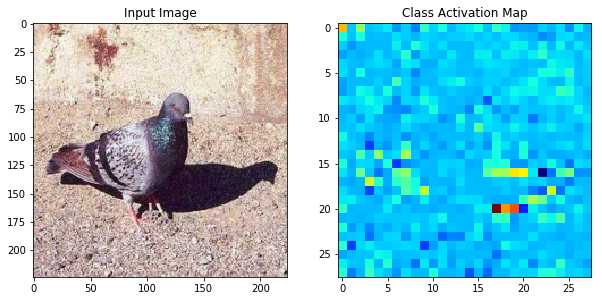

PREDICTED CLASS : 73  (pizza)
     TRUE CLASS : 14  (brain)


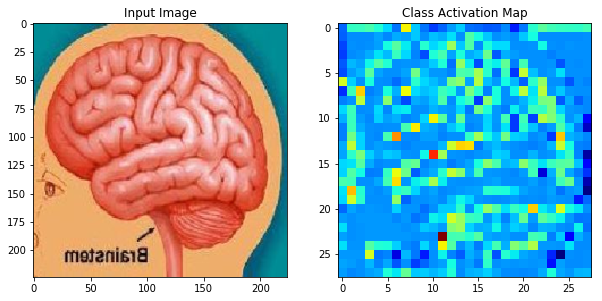

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 4  (Motorbikes)


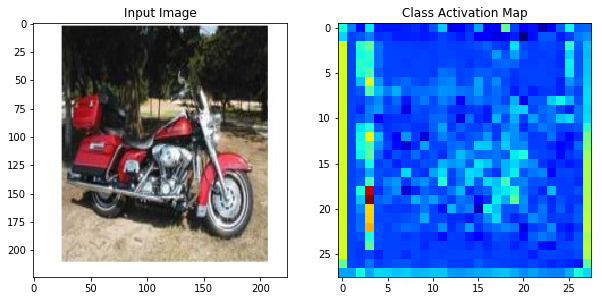

[45/100] cost: 2.7345 train_acc: 0.445 test_acc: 0.438
[50/100] cost: 2.6551 train_acc: 0.492 test_acc: 0.469
PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 6  (airplanes)


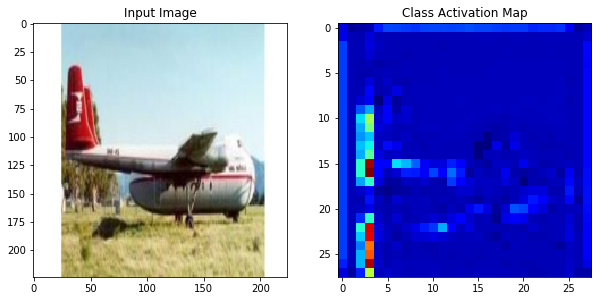

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 6  (airplanes)


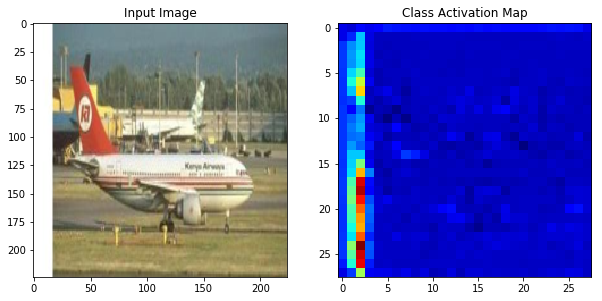

PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 6  (airplanes)


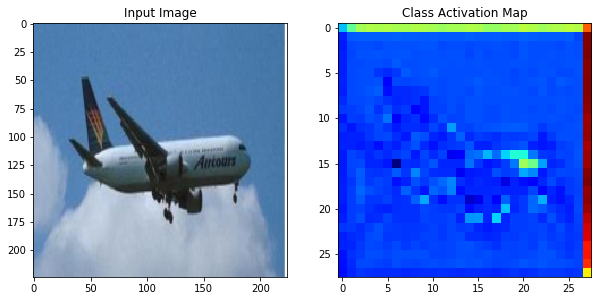

PREDICTED CLASS : 1  (Faces)
     TRUE CLASS : 1  (Faces)


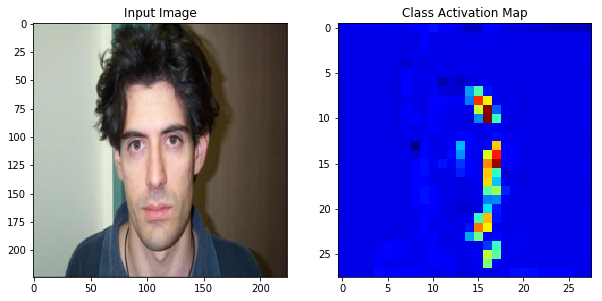

PREDICTED CLASS : 5  (accordion)
     TRUE CLASS : 5  (accordion)


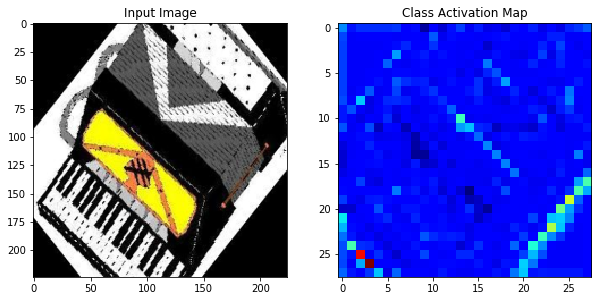

[55/100] cost: 2.5031 train_acc: 0.562 test_acc: 0.430
[60/100] cost: 2.3976 train_acc: 0.562 test_acc: 0.406
PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 4  (Motorbikes)


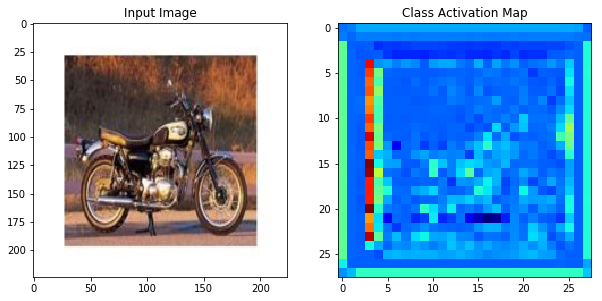

PREDICTED CLASS : 23  (chair)
     TRUE CLASS : 23  (chair)


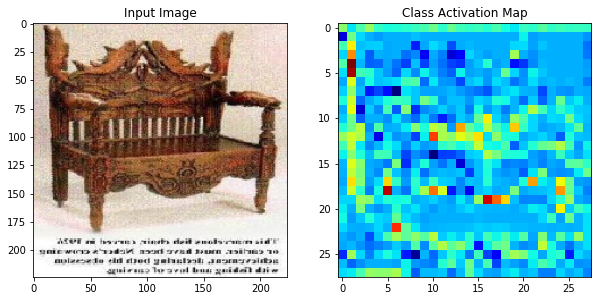

PREDICTED CLASS : 2  (Faces_easy)
     TRUE CLASS : 28  (crayfish)


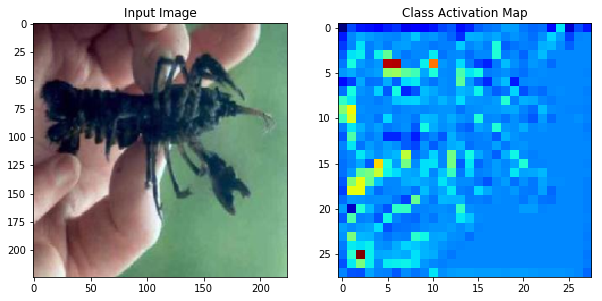

PREDICTED CLASS : 14  (brain)
     TRUE CLASS : 36  (electric_guitar)


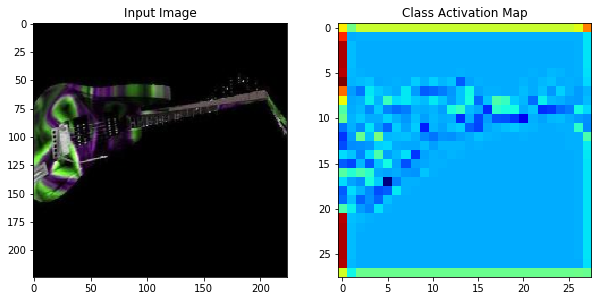

PREDICTED CLASS : 1  (Faces)
     TRUE CLASS : 1  (Faces)


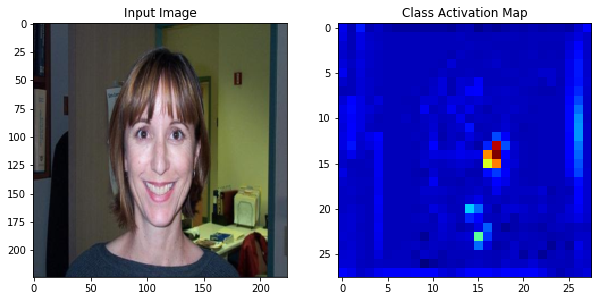

[65/100] cost: 2.3234 train_acc: 0.484 test_acc: 0.430
[70/100] cost: 2.1935 train_acc: 0.461 test_acc: 0.477
PREDICTED CLASS : 87  (starfish)
     TRUE CLASS : 86  (stapler)


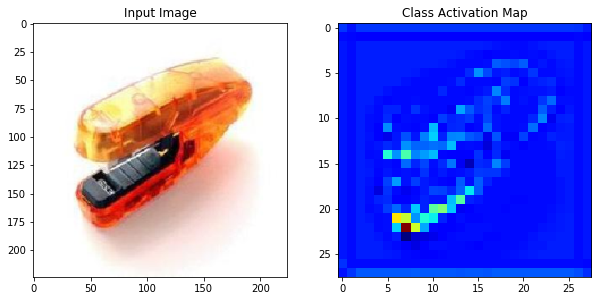

PREDICTED CLASS : 13  (bonsai)
     TRUE CLASS : 23  (chair)


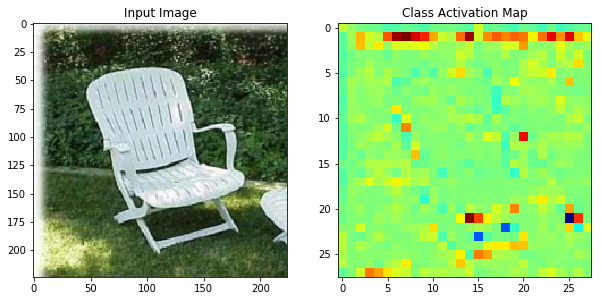

PREDICTED CLASS : 2  (Faces_easy)
     TRUE CLASS : 2  (Faces_easy)


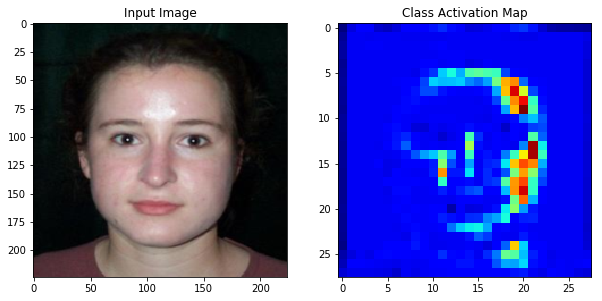

PREDICTED CLASS : 85  (soccer_ball)
     TRUE CLASS : 53  (inline_skate)


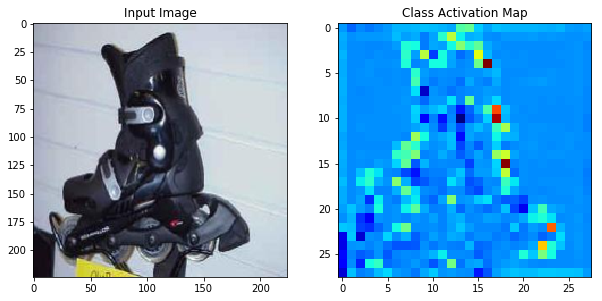

PREDICTED CLASS : 4  (Motorbikes)
     TRUE CLASS : 18  (camera)


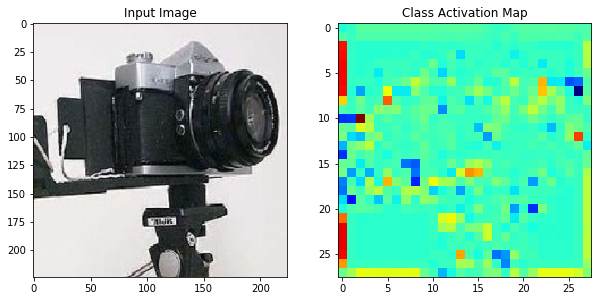

[75/100] cost: 2.1043 train_acc: 0.539 test_acc: 0.375
[80/100] cost: 2.0283 train_acc: 0.672 test_acc: 0.516
PREDICTED CLASS : 41  (ferry)
     TRUE CLASS : 4  (Motorbikes)


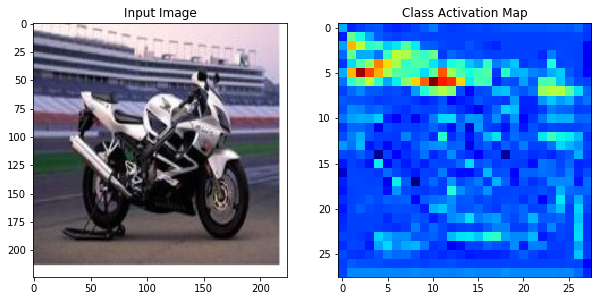

PREDICTED CLASS : 13  (bonsai)
     TRUE CLASS : 73  (pizza)


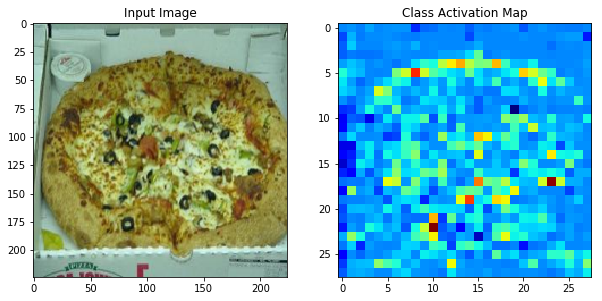

PREDICTED CLASS : 2  (Faces_easy)
     TRUE CLASS : 2  (Faces_easy)


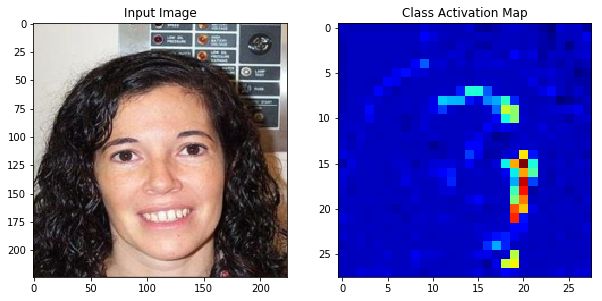

PREDICTED CLASS : 3  (Leopards)
     TRUE CLASS : 3  (Leopards)


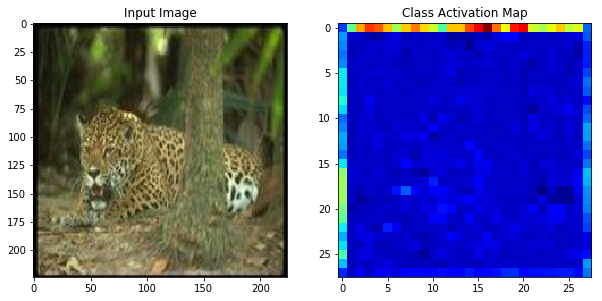

PREDICTED CLASS : 85  (soccer_ball)
     TRUE CLASS : 85  (soccer_ball)


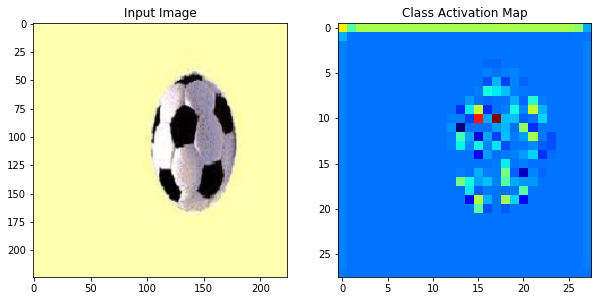

[85/100] cost: 1.9391 train_acc: 0.602 test_acc: 0.492
[90/100] cost: 1.8422 train_acc: 0.719 test_acc: 0.523
PREDICTED CLASS : 6  (airplanes)
     TRUE CLASS : 6  (airplanes)


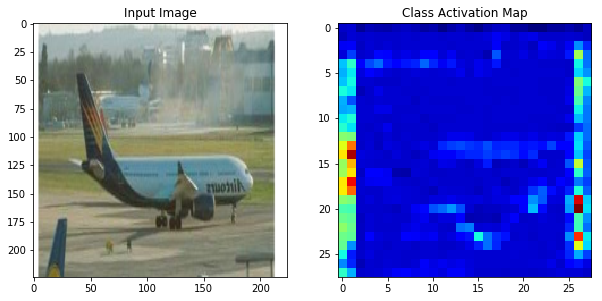

PREDICTED CLASS : 1  (Faces)
     TRUE CLASS : 90  (strawberry)


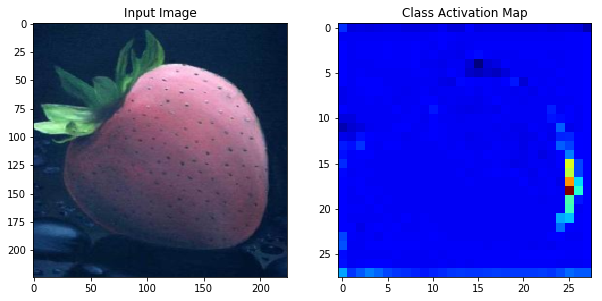

PREDICTED CLASS : 32  (dalmatian)
     TRUE CLASS : 62  (mandolin)


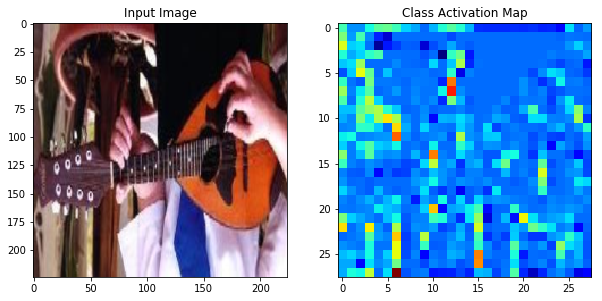

PREDICTED CLASS : 46  (gramophone)
     TRUE CLASS : 57  (lamp)


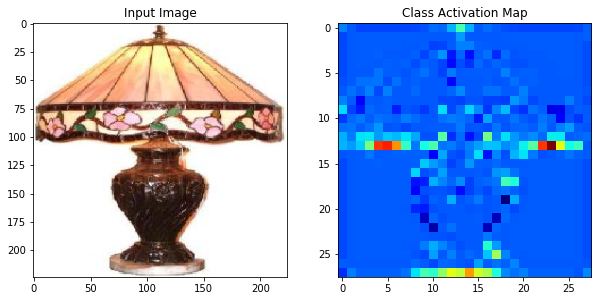

PREDICTED CLASS : 66  (minaret)
     TRUE CLASS : 66  (minaret)


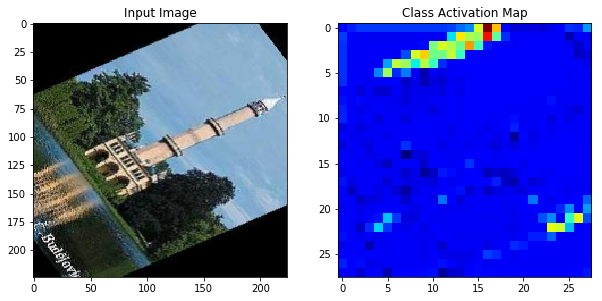

[95/100] cost: 1.7457 train_acc: 0.742 test_acc: 0.445
OPTIMIZATION FINISHED


In [16]:
# SOME PARAMETERS
training_epochs = 100
batch_size   = 128
total_batch  = (ntrain // batch_size) + 1
disp_step    = 5
plot_step    = 10 
for epoch in range(training_epochs):
    avg_cost = 0.
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_x = train_imgs_tensor[randidx, :, :, :]
        batch_y = train_labels_tensor[randidx, :]
        feeds_iter = {x: batch_x, y: batch_y, kr: 0.7}
        _, c = sess.run([optm, cost], feed_dict=feeds_iter)
        avg_cost += c 
    avg_cost = avg_cost / total_batch
    if epoch % disp_step == 0:
        feeds_train = {x: batch_x, y: batch_y, kr: 1.}
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_idx = np.random.randint(len(test_imgs_tensor), size=128)
        test_imgs_temp = test_imgs_tensor[test_idx, :, :, :]
        test_labels_temp = test_labels_tensor[test_idx, :]
        feeds_test = {x: test_imgs_temp, y: test_labels_temp, kr: 1.}
        test_acc = sess.run(accr, feed_dict=feeds_test)
        print ("[%d/%d] cost: %.4f train_acc: %.3f test_acc: %.3f" 
               % (epoch, training_epochs, avg_cost, train_acc, test_acc))
        saver.save(sess, 'data/nets/cam_resnet_caltech101.ckpt', global_step=epoch)        
    if epoch % plot_step == 0:
        # PLOT
        ntest   = test_imgs_tensor.shape[0]
        randidx = np.random.randint(ntest, size=5)
        for idx in randidx:
            testimg = test_imgs_tensor[idx, :, :, :]
            testimg = testimg.reshape((-1,) + testimg.shape)
            testlabel = np.argmax(test_labels_tensor[idx, :])
            
            cam_testfeat, cam_outval, cam_weights = sess.run([gap, pred, weights['out']],
                                feed_dict={x: testimg, kr: 1.})
            predlabel   = np.argmax(cam_outval)
            predweights = cam_weights[:, predlabel]
            camsum = np.zeros((28, 28))
            for i in xrange(256): 
                camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]
            camavg = camsum / 256.

            print "PREDICTED CLASS : %d  (%s)" % (predlabel, categories[predlabel])
            print "     TRUE CLASS : %d  (%s)" % (testlabel, categories[testlabel])
            # PLOT
            fig1 = plt.figure(figsize=(10, 6))
            ax1 = fig1.add_subplot(1,2,1)     
            ax1.imshow(testimg[0])
            ax1.set_title("Input Image")
            ax2 = fig1.add_subplot(1,2,2)     
            im2 = ax2.imshow(camavg, origin='upper', cmap='jet')
            ax2.set_title("Class Activation Map")
            # plt.colorbar(im2, ax=ax2)
            plt.show()
print ("OPTIMIZATION FINISHED")

## TEST

PREDICTED CLASS : 95  (watch)
     TRUE CLASS : 95  (watch)


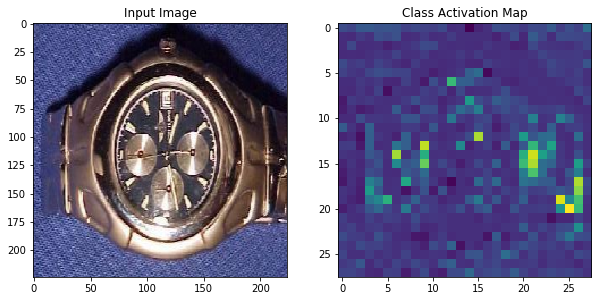

PREDICTED CLASS : 40  (ewer)
     TRUE CLASS : 40  (ewer)


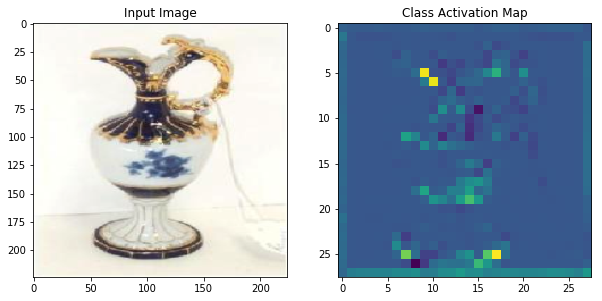

PREDICTED CLASS : 9  (barrel)
     TRUE CLASS : 57  (lamp)


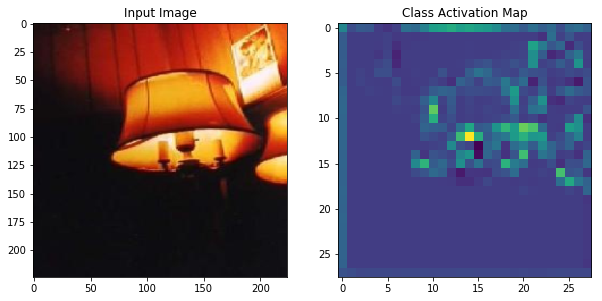

PREDICTED CLASS : 36  (electric_guitar)
     TRUE CLASS : 18  (camera)


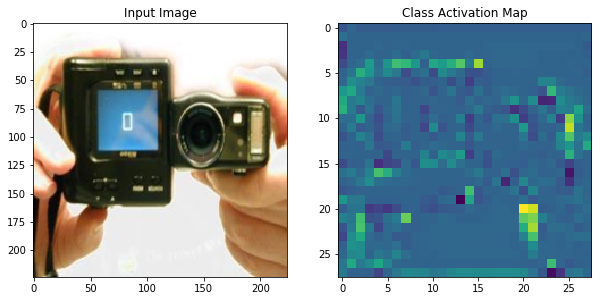

PREDICTED CLASS : 56  (ketch)
     TRUE CLASS : 31  (cup)


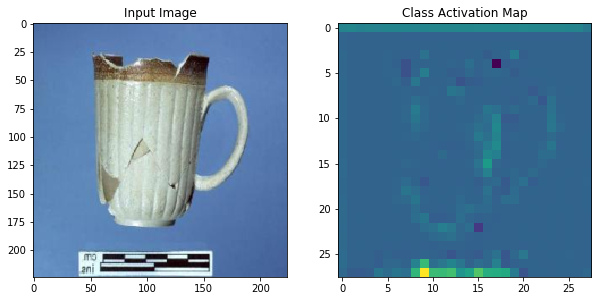

In [19]:
ntest   = test_imgs_tensor.shape[0]
randidx = np.random.randint(ntest, size=5)
for idx in randidx:
    testimg = test_imgs_tensor[idx, :, :, :]
    testimg = testimg.reshape((-1,) + testimg.shape)
    testlabel = np.argmax(test_labels_tensor[idx, :])

    cam_testfeat, cam_outval, cam_weights = sess.run([gap, pred, weights['out']],
                        feed_dict={x: testimg, kr: 1.})
    predlabel   = np.argmax(cam_outval)
    predweights = cam_weights[:, predlabel]
    camsum = np.zeros((28, 28))
    for i in xrange(256): 
        camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]
    camavg = camsum / 256.

    print "PREDICTED CLASS : %d  (%s)" % (predlabel, categories[predlabel])
    print "     TRUE CLASS : %d  (%s)" % (testlabel, categories[testlabel])
    # PLOT
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(1,2,1)     
    ax1.imshow(testimg[0])
    ax1.set_title("Input Image")
    ax2 = fig1.add_subplot(1,2,2)     
    im2 = ax2.imshow(camavg, origin='upper')
    ax2.set_title("Class Activation Map")
    # plt.colorbar(im2, ax=ax2)
    plt.show()